In [87]:
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import pylab
import scipy.stats as ss
import csv
import numpy as np
import sklearn
import glob
from io import StringIO
from sklearn.model_selection import train_test_split
from sklearn import datasets
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from collections import Counter

from tfg_tools import *

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Load data: this loads data in the form of a tensor:

Pats x reviews x features



In [13]:
X_train = np.load('Conjunto_train.npy')
X_test = np.load('Conjunto_test.npy')
y_train = np.load('Labels_train.npy')
y_test = np.load('Labels_test.npy')

In [14]:
#Matrices dimensions

print(y_train.shape)
print(X_train.shape)
print(y_test.shape)
print(X_test.shape)

(1317,)
(1317, 13, 22)
(330,)
(330, 13, 22)


#### For over reviews

* for over the reviews, for each review, we are going to extract the corresponding matrix. This is the main loop, in order to keep things clear, most of the code is going to be encapsulated in the pthon script.
* We are going to use only the first 10 reviews

In [94]:
## function train_rf_review_model
## Note: after check that it works properly it is going to be encapsulated into the tfg_tools.py

from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.model_selection import GridSearchCV

def train_rf_review_model(X_train, y_train, imputed_data,rev_i, prob_rev):
    """
    X_train: matrix pat X features for the corresponding rev_i
    y_train: labels
    imputed_data: data to be use in the imputation
    rev_i: number of review,
    prob_rev: probabilities from previoues reviews to link each of the models
    """
    
    rf_rev = []
    p_rev = []
    #link models with probabilities
    
    if len(prob_rev[i]) == 0:
        #first review, no link at all
        x_train = X_train
        print("Shape of X_train after link",X_train.shape)
    else:
        #concatentate the probabilities from previous reviews
        prb = np.asarray(prob_rev[1:i+1]).T
        print("probability shape",prb.shape)
        X_train = np.concatenate((X_train, prb),axis = 1)
        print("Shape of X_train after link",X_train.shape)
        
    #----------------------------------------------------------------------------------
    #select hypterparameters. 
    #Note, since it is very very imbalanced dataset we are going to limit 
    #drastically the number of samples to be leaf and the same for split
    
    print("-----------------------------------------")
    print("Selecting hyperparameters review ",i)
    
    """
    rf_aux = BalancedRandomForestClassifier(n_estimators=50, criterion='gini',  
                   bootstrap=True, oob_score=False, class_weight = 'balanced_subsample')
    
    #hyperparameters grid
    # Number of features to consider at every split
    max_features = ['auto', 'sqrt','log2']
    # Minimum number of samples required to split a node
    min_samples_split = [4, 5, 10]
    # Minimum number of samples required at each leaf node
    min_samples_leaf = [5,8,10,12,16,20,25]
    # Create the random grid
    grid_search = {'max_features': max_features,
                   'min_samples_split': min_samples_split,
                   'min_samples_leaf': min_samples_leaf}

    
    # Use the random grid to search for best hyperparameters
    # Grid search of parameters, using 7 fold cross validation,

    grid_random = GridSearchCV(rf_aux, grid_search, cv=7 , n_jobs = -1, verbose = 0)

    grid_random.fit(X_train, y_train)
    
    """
    
    #let's use to work faster, then for the final solution try best ones
    max_features = 'sqrt'
    min_samples_split = 10
    min_samples_leaf = 16
    #--------------------------------------------------------------------------------
    
    print("--------------------------------------------")
    print("Note this is going to take a while")
    print("Training the final model review ",i)
    
    rf_rev = BalancedRandomForestClassifier(n_estimators=100, criterion='gini', max_features = max_features,
                min_samples_leaf = min_samples_leaf, min_samples_split = min_samples_split,    
                   bootstrap=True, oob_score=False, class_weight = 'balanced_subsample',n_jobs=-1,verbose =0)
    
    rf_rev.fit(X_train,y_train)
    
    print("--------------------------------------------")
    print("--------------------------------------------")
    
    #--------------------------------------------------------------------------------
    
    #Estimating probabilities
    p_rev = rf_rev.predict_proba(X_train)[:,1]
    
    return rf_rev, p_rev

In [96]:
#features_names
feature_names = ['Age','Weight','Size','IMC','Creatinine','Cystatin','HDL','LDL','Triglyciredes','GOT','GPT','GGT','Albuminuria','Ferritin','HOMA','Insulin','Blood_Glucose','Glycated-HB','PCR','Vitamin-D','TAS','TAD','Date']

# for over reviews

num_reviews = 10

rf_reviews_model = []
prob_rev = [[]]


#imputing data
  #
    
#TODO:remove patients with a given number of NaN. In some advanced reviews the number of patients with differ than 
#NaNs decreases, then it would be needed to remove patients with more than a given number of NaNs 

#Implement this inside imputing_data

X_train_imputed, imputed_data = imputing_data(X_train,num_reviews)

#check

X_train_imputed = X_train_imputed[:num_reviews-4]

for i, X_rev in enumerate(X_train_imputed):
    print(len(prob_rev))
    if i>0:
        print(prob_rev[i][0])
    # train the model
    
    #print(X_rev)
    rf_rev_model, p_rev = train_rf_review_model(X_rev, y_train, imputed_data,i,prob_rev)
    
    #append_models
    rf_reviews_model.append(rf_rev_model)
    prob_rev.append(p_rev)
    
    


review 0
review 1
review 2
review 3
review 4
review 5
review 6
review 7
review 8
review 9
1
Shape of X_train after link (1317, 21)
-----------------------------------------
Selecting hyperparameters review  0
--------------------------------------------
Note this is going to take a while
Training the final model review  0
--------------------------------------------
--------------------------------------------
2
0.2774171575366477
probability shape (1317, 1)
Shape of X_train after link (1317, 22)
-----------------------------------------
Selecting hyperparameters review  1
--------------------------------------------
Note this is going to take a while
Training the final model review  1
--------------------------------------------
--------------------------------------------
3
0.2438796288312456
probability shape (1317, 2)
Shape of X_train after link (1317, 23)
-----------------------------------------
Selecting hyperparameters review  2
--------------------------------------------
Note

In [98]:
rf_reviews_model

y_train[0]

0

In [90]:
#Save models in to not train them every time
from joblib import dump, load


dump(rf_reviews_model,'rf_reviews_model')


KeyboardInterrupt: 

In [ ]:
rf_reviews_model = load("rf_reviews_model")

rf_reviews_model

### Results on test plot roc curves

In [91]:
#impute test data

X_test_revs = []
for i in range(num_reviews):
        print("review",i)
        X_test_rev = pd.DataFrame(X_test[:,1,:],columns = feature_names[:-1])
        X_test_rev = X_test_rev.drop('Blood_Glucose',axis = 1)
       # X_test_rev = X_test_rev.drop('Glycated-HB',axis = 1)
        
        #impute
        X_test_rev = X_test_rev.fillna(imputed_data[i])
        
        X_test_revs.append(X_test_rev)


review 0
review 1
review 2
review 3
review 4
review 5
review 6
review 7
review 8
review 9


0
1
(1, 330)
2
(2, 330)
3
(3, 330)
4
(4, 330)
5
(5, 330)
6


IndexError: list index out of range

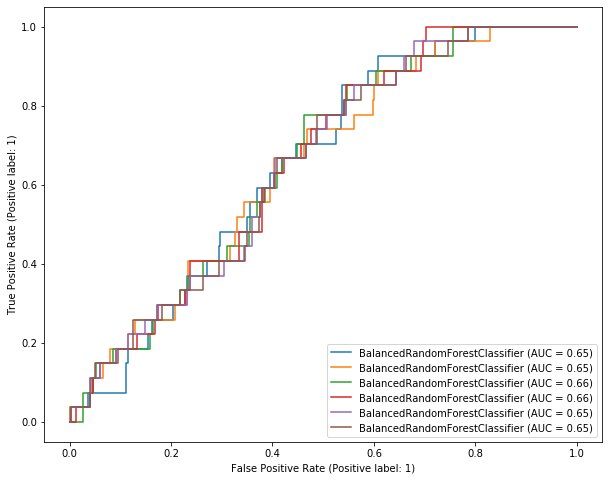

In [93]:
#predict for each test review
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import plot_roc_curve

fig, ax = plt.subplots(figsize = (10,8))

prob_test = []
for i,X_test_rev in enumerate(X_test_revs[:num_reviews]):
    
    print(i)
    rf_rev_model = rf_reviews_model[i]
    
    if i == 0:
        prob_test.append(rf_rev_model.predict_proba(X_test_rev)[:,1])
        
        #fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
        plot_roc_curve(rf_rev_model, X_test_rev,y_test,ax= ax)
        
    else:
        
        #update the X_test with probabilites from previous review
        print(np.asarray(prob_test).shape)
        X_test_rev = np.concatenate((X_test_rev,np.asarray(prob_test).T),axis = 1)
        
        #update prob_test
        prob_test.append(rf_rev_model.predict_proba(X_test_rev)[:,1])
        plot_roc_curve(rf_rev_model, X_test_rev,y_test,ax = ax)

    